Let us first create a bavariate Gaussian distribution.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# We have two dimensions
D = 2

# Setup means
a_mu = 0
b_mu = 0

a_sigma = 1
b_sigma = 1
cov_a_b = 0.5

sigma = np.vstack(((a_sigma, cov_a_b), (cov_a_b, b_sigma)))
mu = np.vstack((a_mu, b_mu))

How to draw samples from this distribution? A simple was is the Cholesky distribution.

The Cholesky algorithm allows to quickly decompose matrix $\Sigma$ into $\Sigma = L L^{T}$

Then to generate random samples from our distribution, we simply have to multiply $L$ by a random vector $R$ ~ $\mathcal{N}(0,1)$

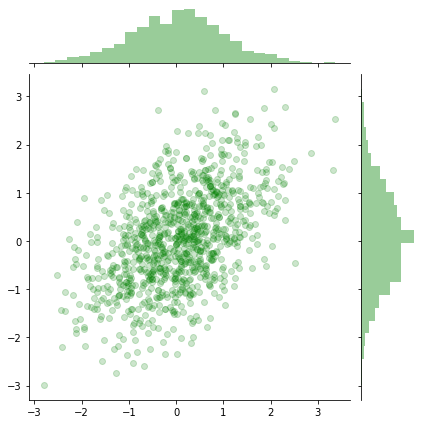

In [17]:
chol = np.linalg.cholesky(sigma)
N = 1000
a,b, = [0]*N, [0]*N
for i in range(N):
    a[i],b[i] = mu + chol @ np.random.normal(size=(2,1))
    
joint = sns.jointplot(x=a, y=b, color='green', alpha=0.2)
plt.show()

# Gibbs sampling

Gibbs sampling draws one of our variables with the others fixed. With our bivariate Gaussian distribution, we get the distribution x given y from this page: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions

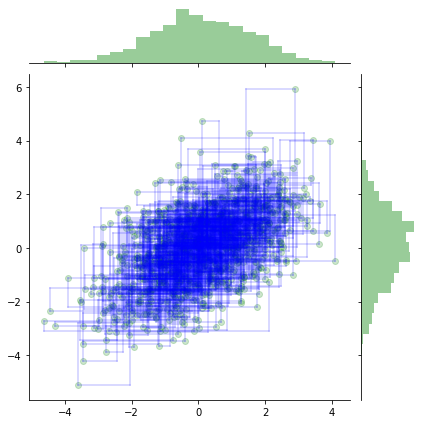

In [34]:
N = 1000
a,b, = [0]*N, [0]*N
for i in range(1, N):
    a_mu_temp = a_mu + cov_a_b * (1/b_sigma) * (b[i-1] - b_mu)
    a_sigma_temp = a_sigma + cov_a_b * (1/b_sigma) * cov_a_b
    a[i] = a_mu_temp + a_sigma_temp * np.random.normal()
    
    b_mu_temp = b_mu + cov_a_b * (1/a_sigma) * (a[i] - a_mu)
    b_sigma_temp = b_sigma + cov_a_b * (1/a_sigma) * cov_a_b
    b[i] = b_mu_temp + b_sigma_temp * np.random.normal()
        
plot = sns.jointplot(x=a, y=b, color='green', alpha=0.2)

# Plot all transitions of the Gibbs Sampling
for i in range(1,N):
    plot.ax_joint.plot([a[i-1],a[i]], [b[i-1],b[i-1]], 'b-', alpha=0.2)
    plot.ax_joint.plot([a[i],a[i]], [b[i-1],b[i]], 'b-', alpha=0.2)
plt.show()

In [ ]:
# Metropolis Hastings Sampling